In [1]:
!nvidia-smi

Tue Mar 21 23:36:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install pycuda scikit-cuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114.8 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp39-cp39-linux_x86_64.whl size=661963 sha256=932ef19c7d9e382f3308998dff154309584dbbb4e9d7710985cf150197fc793b
  Stored in directory: /root/.cache/pip/wheels/82/09/27/74d8e31ed19c530166e0d263aabe1ea57465e255615bda8fc0
  Created wheel for pytools: filename=pytools-2022.1.14-py2.py3-none-any.whl size=69866 sha256=9a90c65715b5ea470e1f83c863001b5eda88cc

In [1]:
from __future__ import division
import pycuda.autoinit
from pycuda import gpuarray
import numpy as np
from skcuda import fft
from skcuda import linalg
from matplotlib import pyplot as plt

import PIL
import urllib
from time import time

/usr/local/lib/python3.9/dist-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
help(fft.fft)

Help on function fft in module skcuda.fft:

fft(x_gpu, y_gpu, plan, scale=False)
    Fast Fourier Transform.
    
    Compute the FFT of some data in device memory using the
    specified plan.
    
    Parameters
    ----------
    x_gpu : pycuda.gpuarray.GPUArray
        Input array.
    y_gpu : pycuda.gpuarray.GPUArray
        FFT of input array.
    plan : Plan
        FFT plan.
    scale : bool, optional
        If True, scale the computed FFT by the number of elements in
        the input array.
    
    Examples
    --------
    >>> import pycuda.autoinit
    >>> import pycuda.gpuarray as gpuarray
    >>> import numpy as np
    >>> from skcuda.fft import fft, Plan
    >>> N = 128
    >>> x = np.asarray(np.random.rand(N), np.float32)
    >>> xf = np.fft.fft(x)
    >>> x_gpu = gpuarray.to_gpu(x)
    >>> xf_gpu = gpuarray.empty(N/2+1, np.complex64)
    >>> plan = Plan(x.shape, np.float32, np.complex64)
    >>> fft(x_gpu, xf_gpu, plan)
    >>> np.allclose(xf[0:N/2+1], xf_gpu.get(), 

In [4]:
# convolution on GPU
def cufft_conv_GPU(x , y):
    
    x = x.astype(np.complex64)
    y = y.astype(np.complex64)
    
    if (x.shape != y.shape):
        return -1
    
    plan = fft.Plan(x.shape, np.complex64, np.complex64)
    inverse_plan = fft.Plan(x.shape, np.complex64, np.complex64)
    
    x_gpu = gpuarray.to_gpu(x)
    y_gpu = gpuarray.to_gpu(y)
    
    x_fft = gpuarray.empty_like(x_gpu, dtype=np.complex64)
    y_fft = gpuarray.empty_like(y_gpu, dtype=np.complex64)
    out_gpu = gpuarray.empty_like(x_gpu, dtype=np.complex64)
    
    fft.fft(x_gpu, x_fft, plan)
    fft.fft(y_gpu, y_fft, plan)
    
    #print(x_fft.shape)
    #print(y_fft.shape)

    linalg.multiply(x_fft, y_fft, overwrite=True)
    
    fft.ifft(y_fft, out_gpu, inverse_plan, scale=True)
    
    conv_out = out_gpu.get()
    
    return conv_out


**Create a filter for the convolution**

In [5]:
gaussian_filter = lambda x, y, sigma : (1 / np.sqrt(2*np.pi*(sigma**2)) )*np.exp( -(x**2 + y**2) / (2 * (sigma**2) ))

def gaussian_ker(sigma):
    ker_ = np.zeros((2*sigma+1, 2*sigma+1))
    
    for i in range(2*sigma + 1):
        for j in range(2*sigma + 1):
            ker_[i,j] = gaussian_filter(i - sigma, j - sigma, sigma)
            
    total_ = np.sum(ker_.ravel())
    
    ker_ = ker_ / total_
    
    return ker_


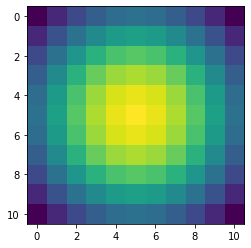

In [6]:
plt.imshow(gaussian_ker(5))

In [7]:
def conv_2d(ker, img):
    
    padded_ker = np.zeros( (img.shape[0] + 2*ker.shape[0],  img.shape[1] + 2*ker.shape[1] )).astype(np.float32)
    
    padded_ker[:ker.shape[0], :ker.shape[1]] = ker
    
    padded_ker = np.roll(padded_ker, shift=-ker.shape[0]//2, axis=0)
    padded_ker = np.roll(padded_ker, shift=-ker.shape[1]//2, axis=1)
    
    padded_img = np.zeros_like(padded_ker).astype(np.float32)
    
    padded_img[ker.shape[0]:-ker.shape[0], ker.shape[1]:-ker.shape[1]] = img
    
    out_ = cufft_conv_GPU(padded_ker, padded_img)
    
    output = out_[ker.shape[0]:-ker.shape[0], ker.shape[1]:-ker.shape[1]]
    
    return output


In [8]:
### load an image
url='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Everest_North_Face_toward_Base_Camp_Tibet_Luca_Galuzzi_2006.jpg/660px-Everest_North_Face_toward_Base_Camp_Tibet_Luca_Galuzzi_2006.jpg'
imdata=np.array(PIL.Image.open(urllib.request.urlopen(url)))

In [9]:
imdata = np.float32(imdata) / 255


In [10]:
ker = gaussian_ker(15)


In [12]:
img_blurred = np.zeros_like(imdata)

t = time()
for k in range(3):
    img_blurred[:,:,k] = conv_2d(ker, imdata[:,:,k])
t = time() - t

<ipython-input-12-77485c6e2946>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  img_blurred[:,:,k] = conv_2d(ker, imdata[:,:,k])
<ipython-input-12-77485c6e2946>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  img_blurred[:,:,k] = conv_2d(ker, imdata[:,:,k])
<ipython-input-12-77485c6e2946>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  img_blurred[:,:,k] = conv_2d(ker, imdata[:,:,k])


In [13]:
print(f'Ellapsed time: {t}')

Ellapsed time: 0.35318422317504883


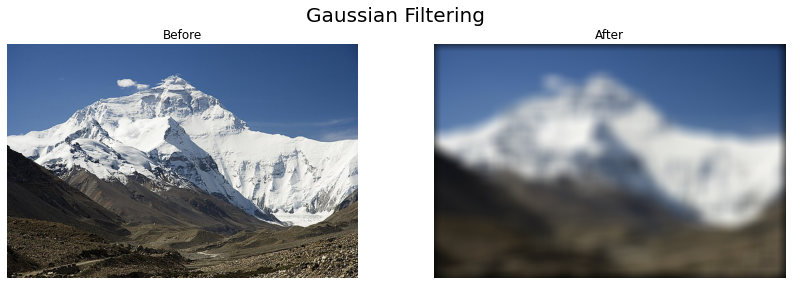

In [14]:
plt.rcParams['figure.figsize'] = [12, 4]
fig, (ax0, ax1) = plt.subplots(1,2)
fig.suptitle('Gaussian Filtering', fontsize=20)
ax0.set_title('Before')
ax0.axis('off')
ax0.imshow(imdata)
ax1.set_title('After')
ax1.axis('off')
ax1.imshow(img_blurred)
plt.tight_layout()
plt.subplots_adjust(top=.85)
plt.show()